# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
CACHE_DIR = "/scratch/chaijy_root/chaijy0/sstorks/.cache/huggingface"
os.environ['HF_HOME'] = CACHE_DIR

1.13.0+cu117
cuda


In [3]:
from transformers import AutoProcessor

MODEL_TYPE = "blip2"
# MODEL_TYPE = "instructblip"
# MODEL_TYPE = "kosmos2"
# MODEL_TYPE = "llava"

if MODEL_TYPE == "blip2":
    MODEL_NAME = "Salesforce/blip2-flan-t5-xxl"
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
elif MODEL_TYPE == "instructblip":
    MODEL_NAME = "Salesforce/instructblip-flan-t5-xxl"
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
elif MODEL_TYPE == "kosmos2":
    MODEL_NAME = "microsoft/kosmos-2-patch14-224"
    from travel.data.utils.image import draw_entity_boxes_on_image
    processor = AutoProcessor.from_pretrained(MODEL_NAME)
elif MODEL_TYPE == "llava":
    MODEL_NAME = "llava-hf/llava-1.5-7b-hf"
    # MODEL_NAME = "llava-hf/llava-v1.6-vicuna-7b-hf"
    # MODEL_NAME = "llava-hf/llava-v1.6-mistral-7b-hf"
    processor = AutoProcessor.from_pretrained(MODEL_NAME)

# CaptainCook4D Data Loading

In [4]:
VIDEO_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv" # Directory containing CaptainCook4D mp4s
ANNOTATIONS_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/annotations"

Boilerplate code to load video frames from video files (from GPT4):

In [5]:
import cv2
import numpy as np

def get_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Cannot open video file")
    
    return cap
    # remember to call cap.release() later

def extract_frames(cap, times):
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frames = []

    for t in times:
        frame_number = int(t * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frames.append(frame)
        else:
            print(f"Warning: Frame at time {t} seconds could not be read.")
            frames.append(None)

    return frames

Other utils functions:

In [6]:
def generate_float_series(start, end, step):
    # Ensure step is a positive float
    step = abs(step)

    # Initialize the series with the start value
    series = [start]

    # Generate numbers in the series
    while start + step <= end:
        start += step
        series.append(start)

    # Check if the end value is already in the series
    if series[-1] != end:
        series.append(end)

    return series

Sample video: /nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv/29_7_360p.mp4
Recipe name: Caprese Bruschetta


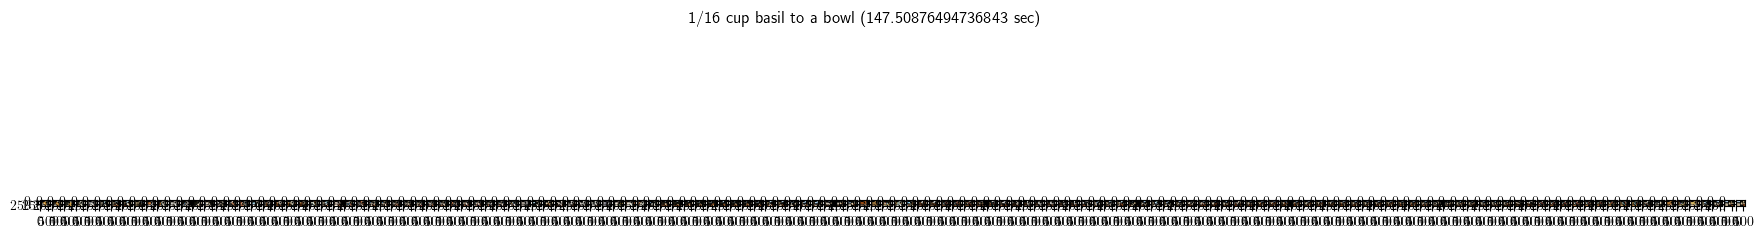

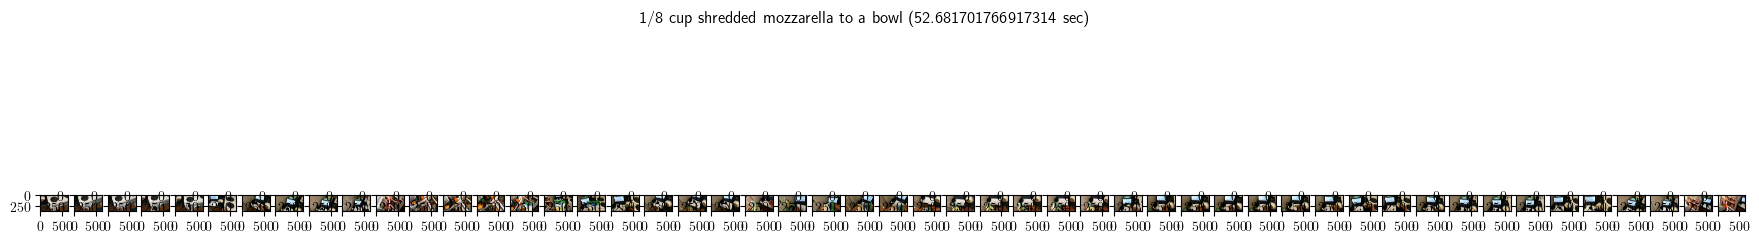

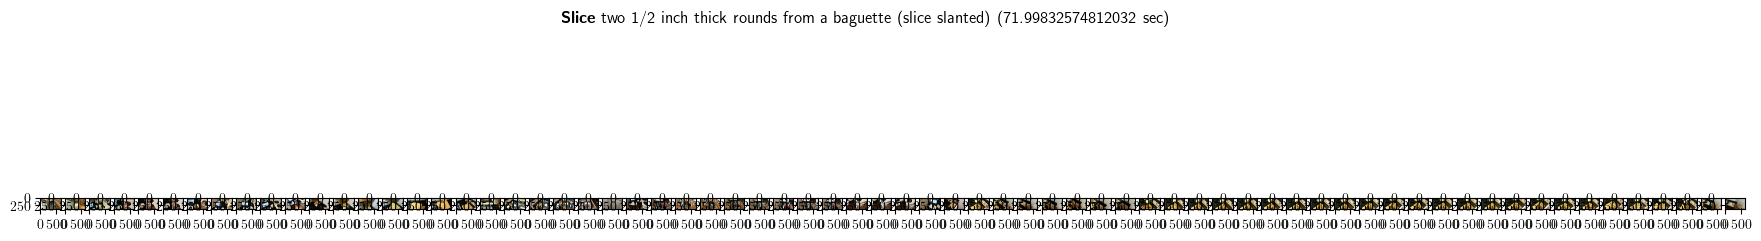

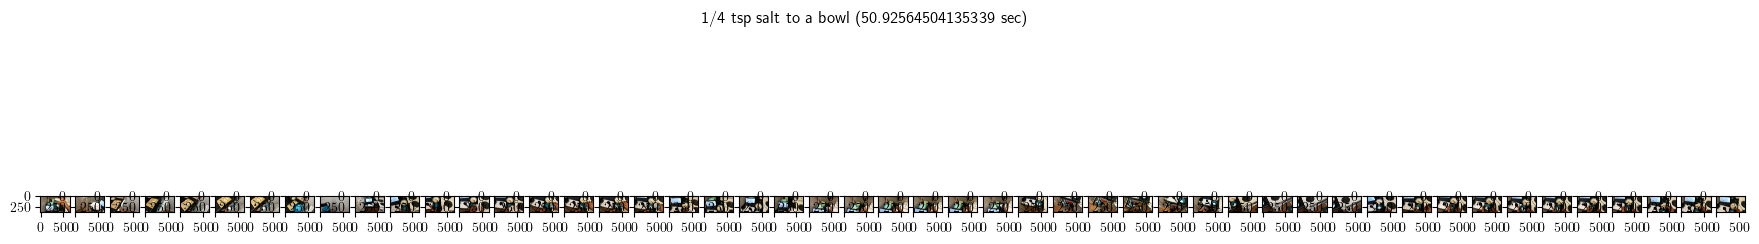

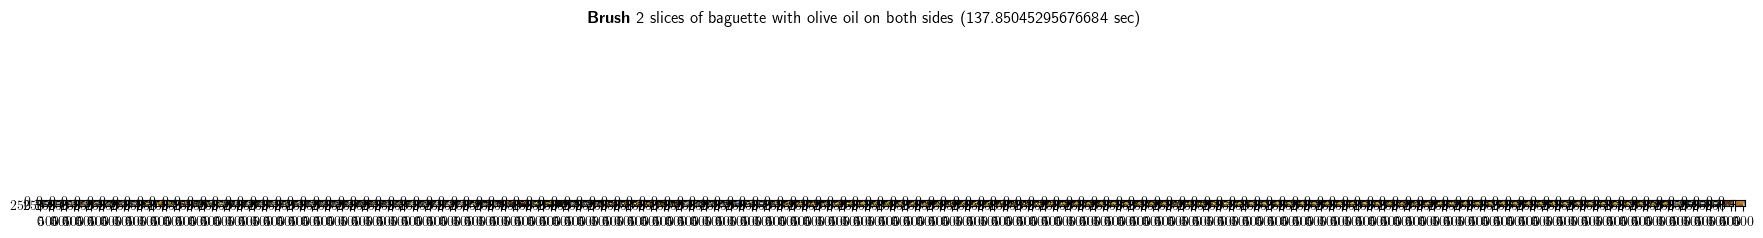

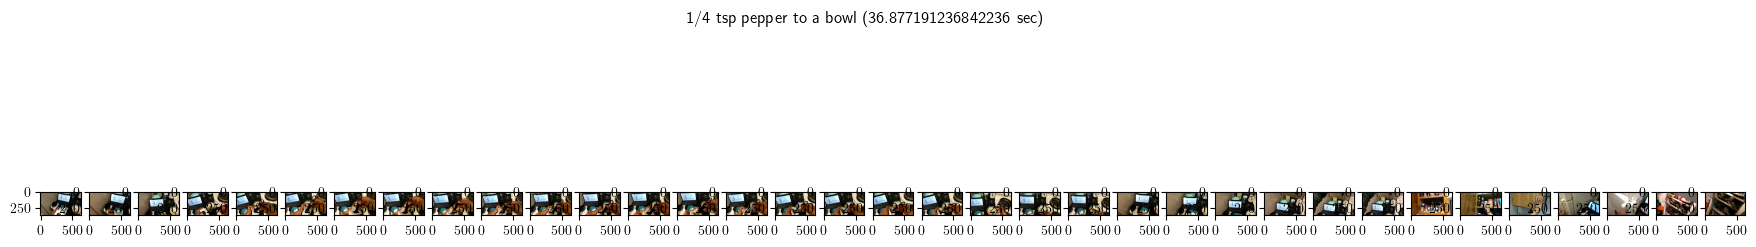

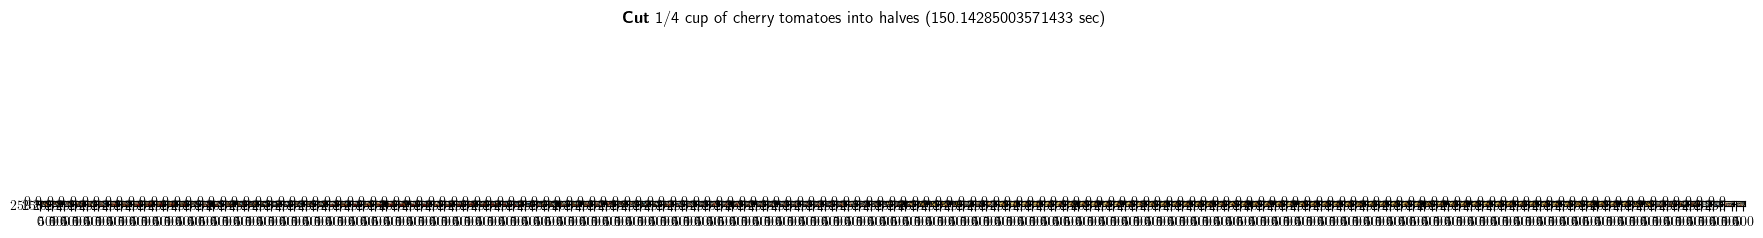

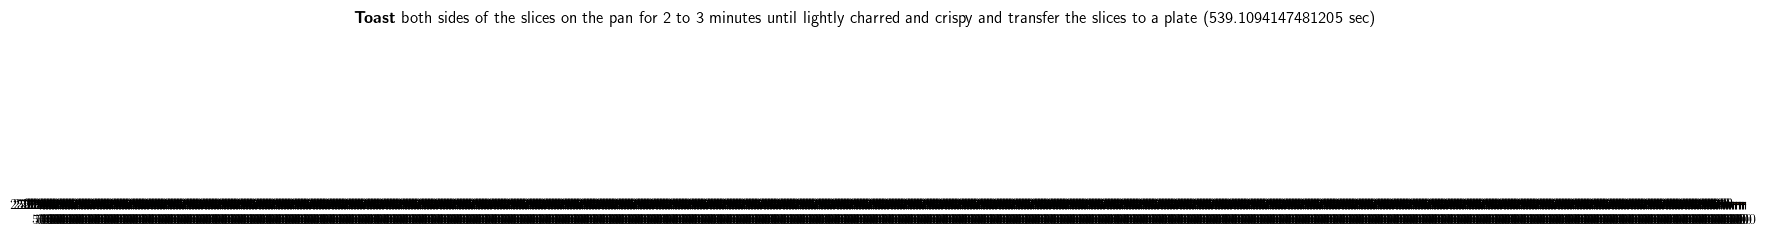

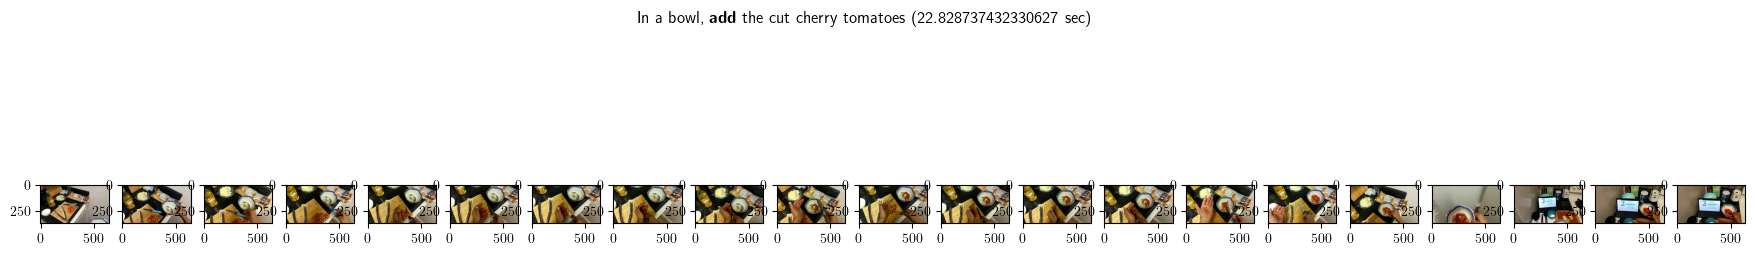

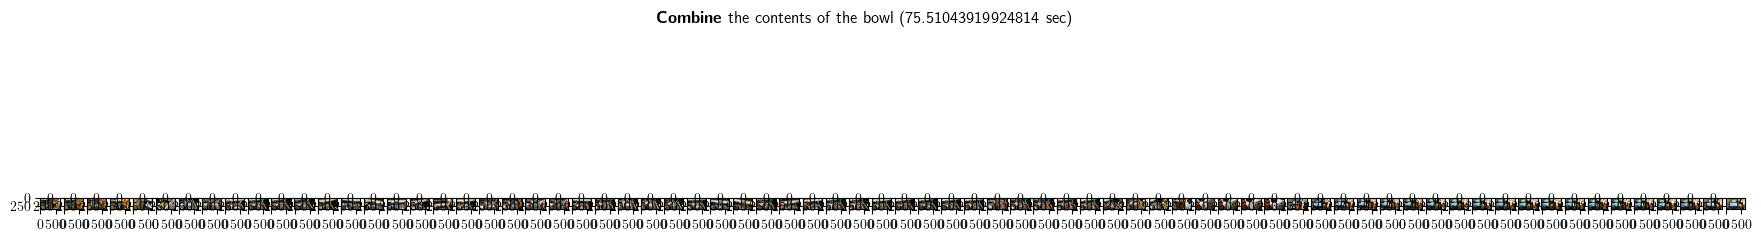

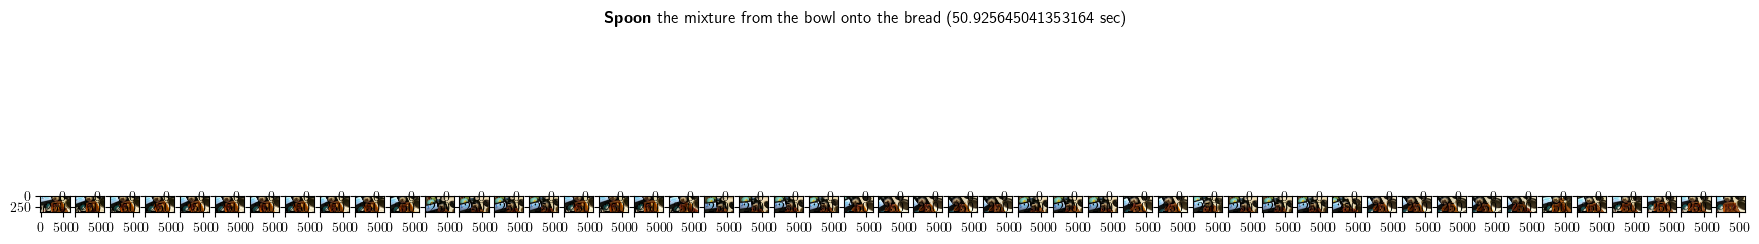

In [7]:
import os, json
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# Pick a sample video from CaptainCook4D
all_video_files = os.listdir(VIDEO_DIR)
sample_video_path = [f for f in all_video_files if f.endswith('.mp4')][3]
sample_video_id = "_".join(sample_video_path.split('_')[:2])
sample_video_path = os.path.join(VIDEO_DIR, sample_video_path)
print("Sample video:", sample_video_path)
sample_video = get_video(sample_video_path)

step_annotations = json.load(open(os.path.join(ANNOTATIONS_DIR, "annotation_json/complete_step_annotations.json"), "r"))
print("Recipe name:", step_annotations[sample_video_id]["activity_name"])

all_frames = []

# Load step annotations for it and display precondition/effect frames
for step in step_annotations[sample_video_id]["steps"]:
    # Extract some keyframes for the action
    pnr = (step['start_time'] + step['end_time']) / 2.0 # take "point of no return" as midpoint of action
    step_duration = step['end_time'] - step['start_time']

    # Some steps are skipped
    if step_duration < 0.1:
        continue

    # TODO: this method of adjusting the start and end times still doesn't account for noise in labels. Maybe we can use segment anything or GLIP to smooth this a bit later.
    # ^ however, we might just end up running a model on several frames, e.g., 1s apart, so this may not matter - just for illustration purpose for now
    adjusted_start = step['start_time'] + min(step_duration * 0.05, 0.5) # Adjust the start time to be later by a maximum of 3 seconds
    adjusted_end = step['end_time'] - min(step_duration * 0.3, 3) # Adjust the end time to be earlier by a maximum of 3 seconds

    # times = [adjusted_start, pnr, adjusted_end]
    SAMPLE_FREQUENCY = 1.0
    times = generate_float_series(adjusted_start, adjusted_end, SAMPLE_FREQUENCY) # ultimately, we'll want to look at every image frame in some regular interval to determine if there's a mistake
    frames = extract_frames(sample_video, times) 

    fig, axarr = plt.subplots(1, len(times), figsize=(22, 4))

    verb, action_description = step['description'].split("-")[0], "-".join(step['description'].split("-")[1:])
    stylized_title = action_description.replace(verb, r'\textbf{' + verb + '}')

    fig.suptitle(f"{stylized_title} ({step_duration} sec)")
    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
    plt.show()
    
    all_frames.append(frames)

sample_video.release()

# Find and save target frames, get questions

In [8]:
from PIL import Image

target_frames = [
    all_frames[8][5],
    all_frames[8][10],
    all_frames[8][15]
]

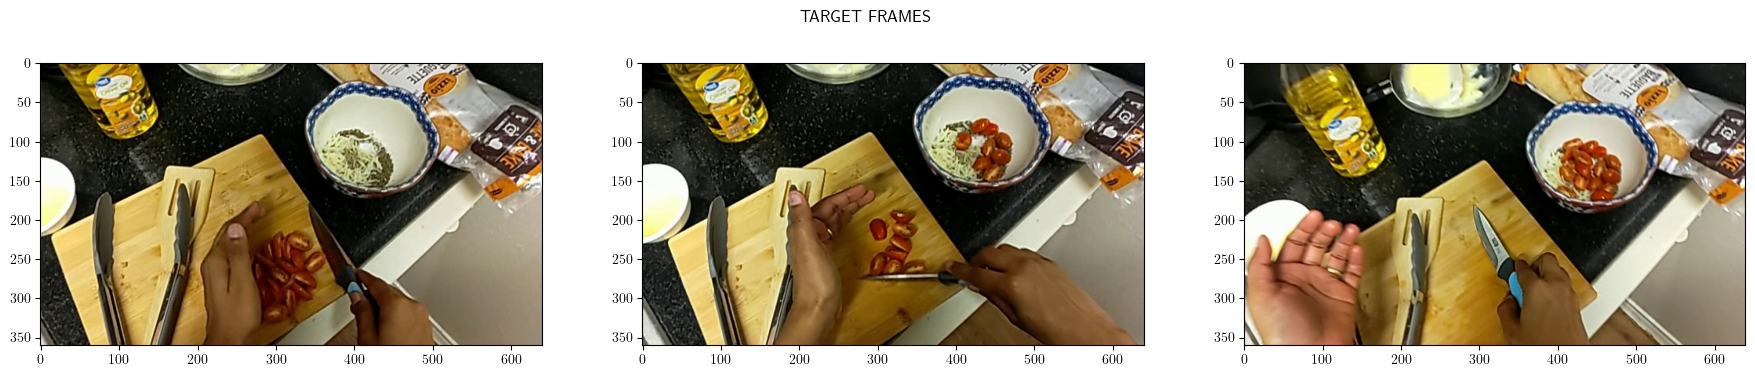

In [9]:
fig, axarr = plt.subplots(1, len(target_frames), figsize=(22, 4))
fig.suptitle("TARGET FRAMES")
for frame, ax in zip(target_frames, axarr):
    if frame is not None:
        ax.imshow(frame)
plt.show()

In [10]:
for fi, frame in enumerate(target_frames):
    Image.fromarray(frame).save(f"./cache_dir/demo_frame{fi}.png")

In [11]:
from travel.model.vqa import COMPLETION_PROMPT_TEMPLATES, SUCCESSVQA_PROMPT_TEMPLATES, VQG2VQA_PROMPT_TEMPLATES, VQAResponse

step = "In a bowl, add the cut cherry tomatoes"
questions = [
    "Are there any cherry tomatoes in the bowl?",
    "Are there any cherry tomatoes that are not in the bowl?"
]

step_masked = f"In a {processor.tokenizer.pad_token}, {processor.tokenizer.pad_token} the {processor.tokenizer.pad_token} {processor.tokenizer.pad_token}"
questions_masked = [
    f"Are there any {processor.tokenizer.pad_token} in the {processor.tokenizer.pad_token}?",
    f"Are there any {processor.tokenizer.pad_token} that are not in the {processor.tokenizer.pad_token}?"
] # It would be interesting if we could replace all these words with their POS, but LM probably can't handle that?

# question_idx = None
# prompt = SUCCESSVQA_PROMPT_TEMPLATES[MODEL_NAME].format(step=step)
# prompt_generic = SUCCESSVQA_PROMPT_TEMPLATES[MODEL_NAME].format(step=step_masked)        

question_idx = 0
prompt = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions[question_idx]) # Are there any cherry tomatoes in the bowl?
prompt_generic = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions_masked[question_idx])

# question_idx = 1
# prompt = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions[question_idx]) # Are there any cherry tomatoes that are not in the bowl?
# prompt_generic = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=questions_masked[question_idx])

answers = [VQAResponse.Yes, VQAResponse.No]

# (Optional) Use OWL and semantic parsing to mask image based on questions

In [74]:
del model

In [12]:
import spacy
from spacy.matcher import Matcher

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def parse_question_for_spatial_focus(question):
    doc = nlp(question)
    target_noun = ""
    negation_present = False
    look_at_noun = True
    spatial_relation = False

    # Function to extract the compound noun if it exists
    def get_compound_noun(token):
        compound = " ".join([child.text for child in token.lefts if child.dep_ == "compound"])
        return compound + " " + token.text if compound else token.text

    for token in doc:
        # Detect negation
        if token.dep_ == "neg":
            negation_present = True

        # For subjects and objects, capture the noun considering compound modifiers
        if token.dep_ in ["nsubj", "attr", "dobj", "pobj"] and token.pos_ == "NOUN":
            target_noun = get_compound_noun(token)
        
        # Identify spatial relations based on specific dependencies
        if token.dep_ == "prep":
            spatial_relation = True

    # Adjust the logic based on question type and negation
    # Spatial questions with negation direct attention away from the noun
    if spatial_relation:
        look_at_noun = not negation_present
    # State questions focus on the noun, negation doesn't change the focus
    else:
        look_at_noun = True

    return (look_at_noun, target_noun)


# TODO: some spatial prepositions, e.g., "outside" may also require negation - but this is enough to get us started

# Test with provided examples
test_questions = [
    "Are there any cherry tomatoes in the bowl?",
    "Are there any cherry tomatoes that are not in the bowl?",
    "Are the cherry tomatoes sliced?",
    "Is the bowl on the cutting board?",
    "Are there any tomatoes that are not sliced?",
]

for q in test_questions:
    print(f"Input: \"{q}\"")
    print("Output:", parse_question_for_spatial_focus(q))


Input: "Are there any cherry tomatoes in the bowl?"
Output: (True, 'bowl')
Input: "Are there any cherry tomatoes that are not in the bowl?"
Output: (False, 'bowl')
Input: "Are the cherry tomatoes sliced?"
Output: (True, 'tomatoes')
Input: "Is the bowl on the cutting board?"
Output: (True, 'cutting board')
Input: "Are there any tomatoes that are not sliced?"
Output: (True, 'tomatoes')


In [13]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# Load OWL object detector for filtering frames, and filter frames
DETECTOR_NAME = "google/owlv2-base-patch16"
detector_processor = Owlv2Processor.from_pretrained(DETECTOR_NAME)
detector = Owlv2ForObjectDetection.from_pretrained(DETECTOR_NAME, load_in_8bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


(True, 'bowl')
[506.71875   38.496094 761.71875  266.48438 ]
[520.3125    23.203125 784.6875   257.57812 ]
[549.84375  76.58203 796.40625 293.4375 ]


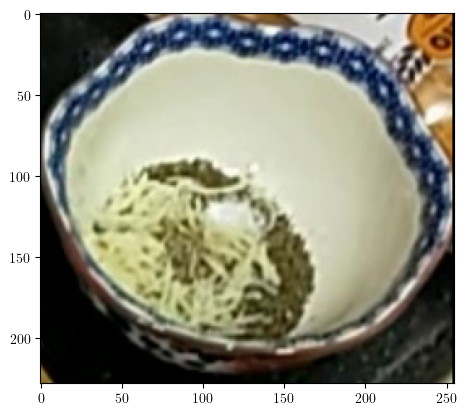

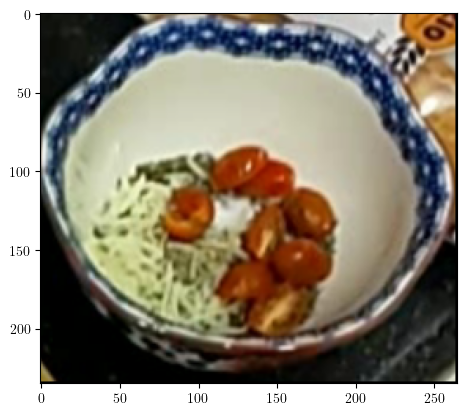

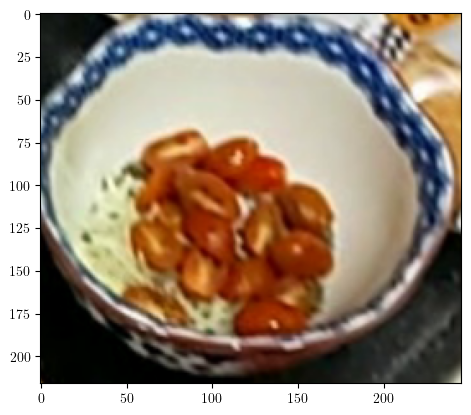

In [14]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from travel.data.utils.image import get_preprocessed_image, BoundingBox, BoundingBoxCluster
from travel.model.grounding import OWL_THRESHOLD

spatial_focus = parse_question_for_spatial_focus(questions[question_idx])
owl_prompts = [f"a photo of {'an' if spatial_focus[1][0] in ['a','e','i','o','u'] else 'a'} {spatial_focus[1]}" for input_img in target_frames]

inputs = detector_processor(text=owl_prompts, images=target_frames, return_tensors="pt").to(detector.device)
outputs = detector(**inputs)
inputs = inputs.to("cpu")

padded_images = [get_preprocessed_image(inputs.pixel_values[j].detach().to('cpu')) for j in range(len(target_frames))]

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([pi.size[::-1] for pi in padded_images])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = detector_processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=OWL_THRESHOLD)

new_frames = []
print(spatial_focus)
for result, frame, frame_padded in zip(results, target_frames, padded_images):
    boxes, scores, labels = result["boxes"], result["scores"], result["labels"]
    bboxes = boxes.detach().cpu().numpy() # (# boxes, 4)

    mask = np.ones((frame_padded.height, frame_padded.width), dtype=np.float64)
    
    # TODO: crop image to the clustered bounding box?
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = map(int, bbox)
        print(bbox)

        # Set the area within the bounding box to 0
        # Note the order: (ymin:ymax, xmin:xmax)
        mask[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])] = 0
        
#         # Define the gradient thickness
#         thickness = 32

#         # Function to calculate distance from a point to the bbox, considering corners
#         def distance_to_bbox(x, y, bbox):
#             xmin, ymin, xmax, ymax = bbox
#             if x < xmin:
#                 if y < ymin:
#                     return np.sqrt((xmin - x)**2 + (ymin - y)**2)  # Bottom left corner
#                 elif y > ymax:
#                     return np.sqrt((xmin - x)**2 + (y - ymax)**2)  # Top left corner
#                 else:
#                     return xmin - x  # Left edge
#             elif x > xmax:
#                 if y < ymin:
#                     return np.sqrt((x - xmax)**2 + (ymin - y)**2)  # Bottom right corner
#                 elif y > ymax:
#                     return np.sqrt((x - xmax)**2 + (y - ymax)**2)  # Top right corner
#                 else:
#                     return x - xmax  # Right edge
#             else:
#                 if y < ymin:
#                     return ymin - y  # Bottom edge
#                 elif y > ymax:
#                     return y - ymax  # Top edge
#                 else:
#                     return 0  # Inside the bbox

#         # Apply the gradient based on distance to the bbox
#         for y in range(frame_padded.height):
#             for x in range(frame_padded.width):
#                 dist = distance_to_bbox(x, y, bbox)
#                 if dist <= thickness:
#                     mask[y, x] = dist / thickness
#                 else:
#                     mask[y, x] = 1
            
#         # Ensure the inside of the bbox is set to 0 after applying the gradient
#         mask[ymin:ymax, xmin:xmax] = 0

    if spatial_focus[0] == True:
        mask = 1 - mask
                    
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

    # Undo padding of image to pass to VLM later
    new_frame = np.array(frame_padded) * mask
    new_frame = Image.fromarray(new_frame.astype(np.uint8))
    frame = Image.fromarray(frame)
    new_height = new_frame.width / frame.width * frame.height
    new_frame = new_frame.crop((0, 0, new_frame.width - 1, new_height))

    if spatial_focus[0] == True:
        # If we're blocking out everything but some bboxes, we can crop out any extra black around the edges of the image
        min_x = np.min(bboxes[:, 0])
        min_y = np.min(bboxes[:, 1])
        max_x = np.max(bboxes[:, 2])
        max_y = np.max(bboxes[:, 3])
        new_frame = new_frame.crop((min_x, min_y, max_x, max_y))     
    
    plt.figure()
    plt.imshow(new_frame)
    new_frames.append(new_frame)

In [15]:
target_frames = [np.array(frame) for frame in new_frames]
del detector_processor
del detector

In [16]:
adjusted_question = "Are there any cherry tomatoes in this photo?"
adjusted_question_masked = f"Are there any {processor.tokenizer.pad_token} in the {processor.tokenizer.pad_token}?"
prompt = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=adjusted_question)
prompt_generic = VQG2VQA_PROMPT_TEMPLATES[MODEL_NAME].format(question=adjusted_question_masked)

In [17]:
for fi, frame in enumerate(target_frames):
    Image.fromarray(frame).save(f"./cache_dir/demo_frame{fi}_cropped.png")

# VQA demo

## Load model

In [63]:
del model

In [19]:
from transformers import AutoProcessor, AutoModelForVision2Seq, LlavaForConditionalGeneration
from transformers import Blip2Processor, Blip2Model, Blip2ForConditionalGeneration

model = AutoModelForVision2Seq.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR, load_in_8bit=True)
# model = InspectableBlip2.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR, load_in_8bit=True)

model.eval()
print(model.device)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

cuda:0


## Generation from prompts

### Open generation from prompt

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from travel.model.vqa import COMPLETION_PROMPT_TEMPLATES

with torch.no_grad():
    
    for input_img in target_frames:
        
        prompt = COMPLETION_PROMPT_TEMPLATES[MODEL_NAME]
        inputs = processor(text=prompt, images=input_img, return_tensors="pt").to(model.device)

        print("MODEL:", MODEL_TYPE)

        if MODEL_TYPE == "kosmos2":
            generated_ids = model.generate(
                pixel_values=inputs["pixel_values"],
                input_ids=inputs["input_ids"][:, :-1],
                attention_mask=inputs["attention_mask"][:, :-1],
                image_embeds=None, # NOTE: we can input image features directly?
                image_embeds_position_mask=inputs["image_embeds_position_mask"][:, :-1],
                use_cache=False,
                max_new_tokens=50,
            )
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
            processed_text, entities = processor.post_process_generation(processed_text)

            print(processed_text.replace(" A:", "\nA:"))
            draw_entity_boxes_on_image(Image.fromarray(input_img), entities, show=True)        
        else:
            generated_ids = model.generate(**inputs, max_length=128)
            generate_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]        
            plt.figure()
            plt.imshow(input_img)
            print(generate_text.replace("ASSISTANT:", "\nASSISTANT:"))  
        print("\n\n")

### Ask about state of object

MODEL: blip2
sliced and sprinkled with cheese



MODEL: blip2
sliced and tossed with parmesan cheese



MODEL: blip2
sliced and placed in a bowl





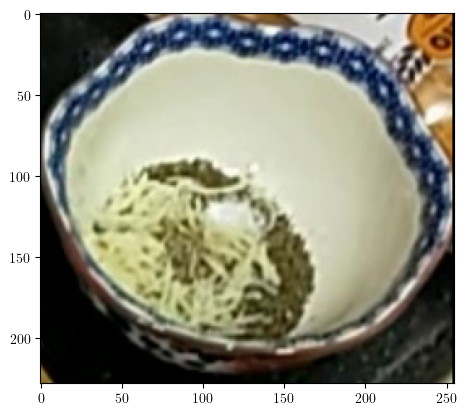

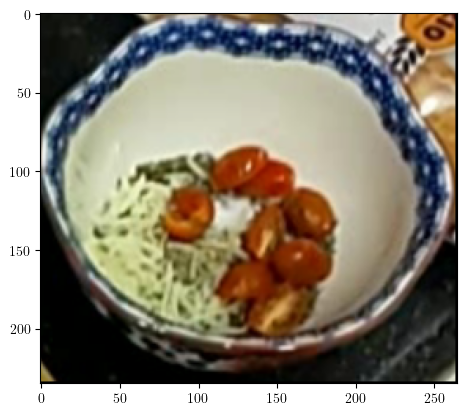

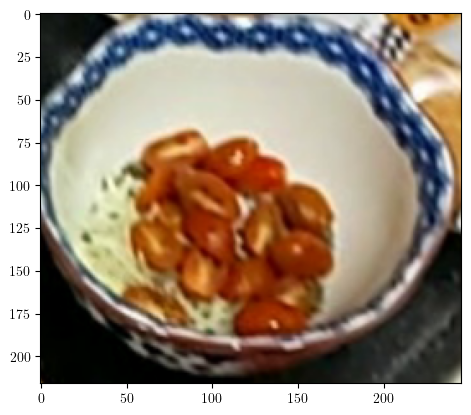

In [43]:
from PIL import Image
import matplotlib.pyplot as plt
from travel.model.vqa import COMPLETION_PROMPT_TEMPLATES

with torch.no_grad():
    
    for input_img in target_frames:
        
        prompt = COMPLETION_PROMPT_TEMPLATES[MODEL_NAME] + " cherry tomatoes. The cherry tomatoes are "
        inputs = processor(text=prompt, images=input_img, return_tensors="pt").to(model.device)

        print("MODEL:", MODEL_TYPE)

        if MODEL_TYPE == "kosmos2":
            generated_ids = model.generate(
                pixel_values=inputs["pixel_values"],
                input_ids=inputs["input_ids"][:, :-1],
                attention_mask=inputs["attention_mask"][:, :-1],
                image_embeds=None, # NOTE: we can input image features directly?
                image_embeds_position_mask=inputs["image_embeds_position_mask"][:, :-1],
                use_cache=False,
                max_new_tokens=50,
            )
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
            processed_text, entities = processor.post_process_generation(processed_text)

            print(processed_text.replace(" A:", "\nA:"))
            draw_entity_boxes_on_image(Image.fromarray(input_img), entities, show=True)        
        else:
            generated_ids = model.generate(**inputs, max_length=128)
            generate_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]        
            plt.figure()
            plt.imshow(input_img)
            print(generate_text.replace("ASSISTANT:", "\nASSISTANT:"))  
        print("\n\n")

### Ask yes/no questions but allow to generate

MODEL: blip2
<pad> no</s>



MODEL: blip2
<pad> no</s>



MODEL: blip2
<pad> no</s>





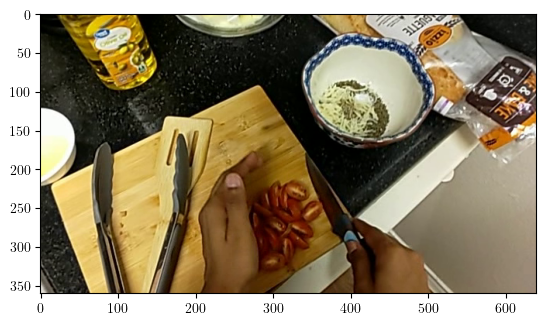

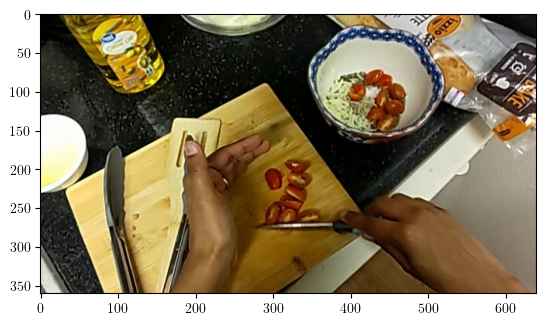

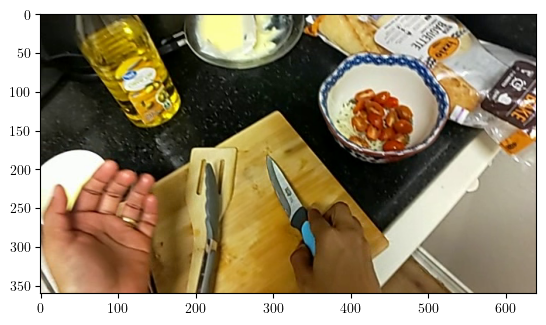

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
from travel.model.vqa import SUCCESSVQA_PROMPT_TEMPLATES, VQG2VQA_PROMPT_TEMPLATES

with torch.no_grad():
    
    for input_img in target_frames:
                
        inputs = processor(text=prompt, images=input_img, return_tensors="pt").to(model.device)

        print("MODEL:", MODEL_TYPE)

        if MODEL_TYPE == "kosmos2":
            generated_ids = model.generate(
                pixel_values=inputs["pixel_values"],
                input_ids=inputs["input_ids"][:, :-1],
                attention_mask=inputs["attention_mask"][:, :-1],
                image_embeds=None, # NOTE: we can input image features directly?
                image_embeds_position_mask=inputs["image_embeds_position_mask"][:, :-1],
                use_cache=False,
                max_new_tokens=50,
            )
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
            processed_text, entities = processor.post_process_generation(processed_text)

            print(processed_text.replace(" A:", "\nA:"))
            draw_entity_boxes_on_image(Image.fromarray(input_img), entities, show=True)        
        else:
            generated_ids = model.generate(**inputs, max_length=256)
            generate_text = processor.batch_decode(generated_ids, skip_special_tokens=False, clean_up_tokenization_spaces=False)[0]        
            plt.figure()
            plt.imshow(input_img)
            print(generate_text.replace("ASSISTANT:", "\nASSISTANT:"))  
        print("\n\n")

## Restricted yes/no answers

Measure probability of yes/no:

In [28]:
import torch
# TODO: why does BLIP-2 generate "no" when it's lower probability than "yes"???? thought it might be a tokenization problem (added <pad> to prompt template), but that might not be the problem...
def get_no_yes_probs(logits, no_id, yes_id):
    max_token = torch.argmax(logits[-2], dim=-1)   
    
    logits = torch.softmax(logits, dim=-1)
    no_logit = logits[-1, no_id]
    yes_logit = logits[-1, yes_id]
    
    no_yes_sum = no_logit + yes_logit
    no_logit /= no_yes_sum
    yes_logit /= no_yes_sum
    probs = torch.stack((no_logit, yes_logit), dim=0).detach().cpu()        
    return probs

MODEL: blip2 

No: 0.619140625
Yes: 0.381103515625

No (prior, no question + no image): 0.55517578125
Yes (prior, no question + no image): 0.44482421875

No (normalized): 0.5654296875
Yes (normalized): 0.434326171875



No: 0.59716796875
Yes: 0.4033203125

No (prior, no question + no image): 0.55517578125
Yes (prior, no question + no image): 0.44482421875

No (normalized): 0.54248046875
Yes (normalized): 0.457275390625



No: 0.6044921875
Yes: 0.395263671875

No (prior, no question + no image): 0.55517578125
Yes (prior, no question + no image): 0.44482421875

No (normalized): 0.55078125
Yes (normalized): 0.449462890625





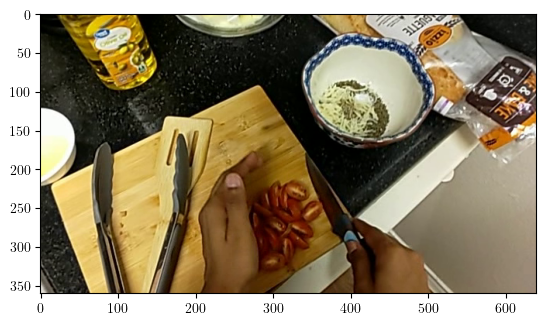

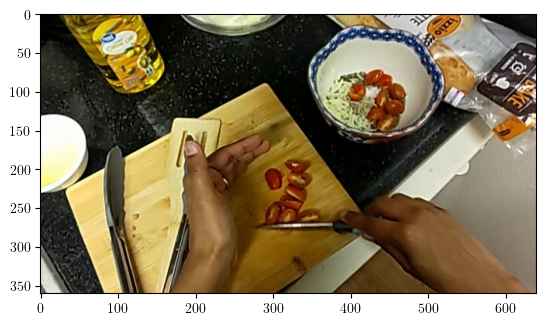

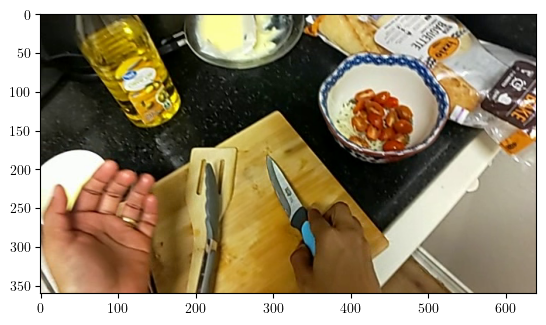

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from travel.model.vqa import VQG2VQA_PROMPT_TEMPLATES, SUCCESSVQA_PROMPT_TEMPLATES, VQAResponse, _shift_right

if MODEL_TYPE == "blip2":
    # BLIP-2 likes lowercase no and yes - later can aggregate all yes and no variations
    NO_ID = processor.tokenizer("no", add_special_tokens=False)['input_ids'][0]
    YES_ID = processor.tokenizer("yes", add_special_tokens=False)['input_ids'][0]
else:
    NO_ID = processor.tokenizer("No", add_special_tokens=False)['input_ids'][0]
    YES_ID = processor.tokenizer("Yes", add_special_tokens=False)['input_ids'][0]    

print("MODEL:", MODEL_TYPE, "\n")

for input_img in target_frames:
    with torch.no_grad():

        inputs = processor(text=prompt, images=input_img, return_tensors="pt").to(device)
        if MODEL_TYPE == "blip2":
            decoder_input_ids = _shift_right(inputs['input_ids'], model.config.text_config.decoder_start_token_id, model.config.text_config.pad_token_id)
            inputs['decoder_input_ids'] = decoder_input_ids
            
        # Model forward pass for normal prompt
        logits = model(**inputs).logits[0] # (seq length, vocab size)
        probs = get_no_yes_probs(logits, NO_ID, YES_ID)
               
        # Estimate prior probability of yes and no for this sequence (using a prompt without the image and with a masked out version of the question)
        input_img_generic = np.random.randint(0, 256, input_img.shape, dtype=np.uint8)
        inputs = processor(text=prompt_generic, images=input_img_generic, return_tensors="pt").to(device)
        if MODEL_TYPE == "blip2":
            decoder_input_ids = _shift_right(inputs['input_ids'], model.config.text_config.decoder_start_token_id, model.config.text_config.pad_token_id)
            inputs['decoder_input_ids'] = decoder_input_ids        
        del inputs['pixel_values']
        if "image_sizes" in inputs:
            del inputs["image_sizes"]
        
        # Model forward pass for generic prompt to normalize yes/no
        if MODEL_TYPE == "kosmos2":
            logits = model.text_model(**inputs).logits[0]
        else:
            logits = model.language_model(**inputs).logits[0]
        # logits = model(**inputs).logits[0]
        probs_prior = get_no_yes_probs(logits, NO_ID, YES_ID)
                         
        probs_normalized = probs.clone()
        probs_normalized /= probs_prior
        probs_normalized_sum = probs_normalized[0] + probs_normalized[1]
        probs_normalized[0] /= probs_normalized_sum
        probs_normalized[1] /= probs_normalized_sum
        
        print(f"No: {probs[0]}\nYes: {probs[1]}\n")
        print(f"No (prior, no question + no image): {probs_prior[0]}\nYes (prior, no question + no image): {probs_prior[1]}\n")
        print(f"No (normalized): {probs_normalized[0]}\nYes (normalized): {probs_normalized[1]}\n")

        print("\n")
        plt.figure()
        plt.imshow(input_img)

# Extra code

In [37]:
print(processor.tokenizer.decode(456))

start


In [20]:

model._get_logits_processor(
            generation_config=model.generation_config,
            input_ids_seq_length=inputs['input_ids'].shape[-1],
            encoder_input_ids=inputs['input_ids'],
            prefix_allowed_tokens_fn=None,
            logits_processor=[]
        )

[]

In [122]:
print(model.generation_config.get_generation_mode(None))

GenerationMode.GREEDY_SEARCH


In [141]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0
}



In [56]:
import inspect
from transformers import Blip2ForConditionalGeneration
from typing import Optional, Union
import torch
from transformers.generation.logits_process import LogitsProcessorList
from transformers.generation.stopping_criteria import StoppingCriteriaList
from transformers.cache_utils import Cache, DynamicCache, StaticCache

NEED_SETUP_CACHE_CLASSES_MAPPING = {
    "static": StaticCache,
}

class InspectableBlip2(Blip2ForConditionalGeneration):
    @torch.no_grad()
    def generate(
        self,
        pixel_values: torch.FloatTensor,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        **generate_kwargs
    ):
        if hasattr(self, "hf_device_map"):
            # preprocess for `accelerate`
            self._preprocess_accelerate()

        batch_size = pixel_values.shape[0]
        image_embeds = self.vision_model(pixel_values, return_dict=True).last_hidden_state
        image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=image_embeds.device)

        query_tokens = self.query_tokens.expand(image_embeds.shape[0], -1, -1)
        query_outputs = self.qformer(
            query_embeds=query_tokens,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_attention_mask,
            return_dict=True,
        )
        query_output = query_outputs.last_hidden_state

        language_model_inputs = self.language_projection(query_output)
        language_attention_mask = torch.ones(
            language_model_inputs.size()[:-1], dtype=torch.long, device=language_model_inputs.device
        )
        if input_ids is None:
            input_ids = (
                torch.LongTensor([[self.config.text_config.bos_token_id]])
                .repeat(batch_size, 1)
                .to(image_embeds.device)
            )
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        attention_mask = torch.cat([language_attention_mask, attention_mask.to(language_attention_mask.device)], dim=1)

        # concatenate query embeddings with prompt embeddings
        inputs_embeds = self.get_input_embeddings()(input_ids)
        inputs_embeds = torch.cat([language_model_inputs, inputs_embeds.to(language_model_inputs.device)], dim=1)

        # add image_embeds length to max_length, so that the final max_length in counted only on token embeds
        if not self.language_model.config.is_encoder_decoder:
            generate_kwargs["max_length"] = generate_kwargs.get("max_length", 20) + language_model_inputs.shape[1]
            generate_kwargs["min_length"] = generate_kwargs.get("min_length", 0) + language_model_inputs.shape[1]       
        
        kwargs = generate_kwargs
        kwargs['inputs_embeds'] = inputs_embeds
        kwargs['attention_mask'] = attention_mask
        
        # 1. Handle `generation_config` and kwargs that might update it, and validate the `.generate()` call
        self._validate_model_class()
        generation_config, model_kwargs = self._prepare_generation_config(None, **kwargs)
        self._validate_model_kwargs(model_kwargs.copy())

        # 2. Set generation parameters if not already defined
        synced_gpus = False
        logits_processor = LogitsProcessorList()
        stopping_criteria = StoppingCriteriaList()

        if generation_config.pad_token_id is None and generation_config.eos_token_id is not None:
            eos_token_id = generation_config.eos_token_id
            if isinstance(eos_token_id, list):
                eos_token_id = eos_token_id[0]
            generation_config.pad_token_id = eos_token_id

        # 3. Define model inputs
        # inputs_tensor has to be defined
        # model_input_name is defined if model-specific keyword input is passed
        # otherwise model_input_name is None
        # all model-specific keyword inputs are removed from `model_kwargs`
        inputs_tensor, model_input_name, model_kwargs = self._prepare_model_inputs(
            None, generation_config.bos_token_id, model_kwargs
        )
        batch_size = inputs_tensor.shape[0]

        # 4. Define other model kwargs
        model_kwargs["output_attentions"] = generation_config.output_attentions
        model_kwargs["output_hidden_states"] = generation_config.output_hidden_states
        # decoder-only models with inputs_embeds forwarding must use caching (otherwise we can't detect whether we are
        # generating the first new token or not, and we only want to use the embeddings for the first new token)
        if not self.config.is_encoder_decoder and model_input_name == "inputs_embeds":
            model_kwargs["use_cache"] = True
        else:
            model_kwargs["use_cache"] = generation_config.use_cache

        accepts_attention_mask = "attention_mask" in set(inspect.signature(self.forward).parameters.keys())
        requires_attention_mask = "encoder_outputs" not in model_kwargs

        if model_kwargs.get("attention_mask", None) is None and requires_attention_mask and accepts_attention_mask:
            model_kwargs["attention_mask"] = self._prepare_attention_mask_for_generation(
                inputs_tensor, generation_config.pad_token_id, generation_config.eos_token_id
            )

        if self.config.is_encoder_decoder and "encoder_outputs" not in model_kwargs:
            # if model is encoder decoder encoder_outputs are created
            # and added to `model_kwargs`
            model_kwargs = self._prepare_encoder_decoder_kwargs_for_generation(
                inputs_tensor, model_kwargs, model_input_name
            )

        # 5. Prepare `input_ids` which will be used for auto-regressive generation
        if self.config.is_encoder_decoder:
            input_ids, model_kwargs = self._prepare_decoder_input_ids_for_generation(
                batch_size=batch_size,
                model_input_name=model_input_name,
                model_kwargs=model_kwargs,
                decoder_start_token_id=generation_config.decoder_start_token_id,
                bos_token_id=generation_config.bos_token_id,
                device=inputs_tensor.device,
            )
        else:
            input_ids = inputs_tensor if model_input_name == "input_ids" else model_kwargs.pop("input_ids")

        # 6. Prepare `max_length` depending on other stopping criteria.
        input_ids_length = input_ids.shape[-1]
        has_default_max_length = kwargs.get("max_length") is None and generation_config.max_length is not None
        if generation_config.max_new_tokens is not None:
            generation_config.max_length = generation_config.max_new_tokens + input_ids_length

        # otherwise the total length [inputs-embeds-len + new-tokens-len] will go beyond indicated `max_length``
        elif (
            model_input_name == "inputs_embeds"
            and inputs_tensor.shape[:-1] != input_ids.shape
            and not self.config.is_encoder_decoder
        ):
            generation_config.max_length -= inputs_tensor.shape[1]
            generation_config.min_length = max(generation_config.min_length - inputs_tensor.shape[1], 0)

        if generation_config.cache_implementation in NEED_SETUP_CACHE_CLASSES_MAPPING:
            if generation_config.cache_implementation == "static":
                if model_kwargs.get("past_key_values", False) is not False:
                    raise ValueError(
                        "Using `past_key_values` argument with `generate()` when using a static KV cache is not supported. Please open an issue in Transformers GitHub repository."
                    )
                cache_cls = NEED_SETUP_CACHE_CLASSES_MAPPING["static"]
                if not callable(getattr(self, "_setup_cache", None)):
                    raise ValueError(
                        "The `generation_config` defines a `cache_implementation` that is not compatible with this model."
                        " Make sure it has a `_setup_cache` function."
                    )
                self._setup_cache(cache_cls, max_batch_size=batch_size, max_cache_len=generation_config.max_length)

        self._validate_generated_length(generation_config, input_ids_length, has_default_max_length)

        # 7. determine generation mode

        # 8. prepare distribution pre_processing samplers
        prepared_logits_processor = self._get_logits_processor(
            generation_config=generation_config,
            input_ids_seq_length=input_ids_length,
            encoder_input_ids=inputs_tensor,
            prefix_allowed_tokens_fn=None,
            logits_processor=logits_processor,
            model_kwargs=model_kwargs,
            negative_prompt_ids=None,
            negative_prompt_attention_mask=None,
        )
        print(prepared_logits_processor)

        # 9. prepare stopping criteria
        prepared_stopping_criteria = self._get_stopping_criteria(
            generation_config=generation_config, stopping_criteria=stopping_criteria
        )
        # 10. go into different generation modes
        
        # 11. run greedy search
        result = self._greedy_search(
            input_ids,
            logits_processor=prepared_logits_processor,
            stopping_criteria=prepared_stopping_criteria,
            pad_token_id=generation_config.pad_token_id,
            eos_token_id=generation_config.eos_token_id,
            output_scores=True,
            output_logits=generation_config.output_logits,
            return_dict_in_generate=generation_config.return_dict_in_generate,
            synced_gpus=synced_gpus,
            streamer=None,
            **model_kwargs,
        )
        
        # outputs = self.language_model.generate(
        #     inputs_embeds=inputs_embeds,
        #     attention_mask=attention_mask,
        #     **generate_kwargs,
        # )
        return result    

In [ ]:
# del model
model = YesNoLMForConditionalGeneration.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR, load_in_8bit=True)
# model = YesNoLMForConditionalGeneration(model)

In [62]:
import inspect
print(inspect.signature(model.language_model.generate))

(inputs: Optional[torch.Tensor] = None, generation_config: Optional[transformers.generation.configuration_utils.GenerationConfig] = None, logits_processor: Optional[transformers.generation.logits_process.LogitsProcessorList] = None, stopping_criteria: Optional[transformers.generation.stopping_criteria.StoppingCriteriaList] = None, prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None, synced_gpus: Optional[bool] = None, assistant_model: Optional[ForwardRef('PreTrainedModel')] = None, streamer: Optional[ForwardRef('BaseStreamer')] = None, negative_prompt_ids: Optional[torch.Tensor] = None, negative_prompt_attention_mask: Optional[torch.Tensor] = None, **kwargs) -> Union[transformers.generation.utils.GenerateDecoderOnlyOutput, transformers.generation.utils.GenerateEncoderDecoderOutput, transformers.generation.utils.GenerateBeamDecoderOnlyOutput, transformers.generation.utils.GenerateBeamEncoderDecoderOutput, torch.LongTensor]
